In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sn
import warnings
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import accuracy_score
from yellowbrick.model_selection import ValidationCurve #pip install yellowbrick before running this command
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ROCAUC
import scikitplot as skplt
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.cluster import KMeans
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
data = pd.read_csv("C:/Users/adity/Downloads/ML/training_data.csv", na_values=['?'])
data.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,...,No,No,No,No,No,No,No,No,No,N
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,N
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,N
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,N
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,N


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81414 entries, 0 to 81413
Data columns (total 50 columns):
encounter_id                81414 non-null int64
patient_nbr                 81414 non-null int64
race                        79601 non-null object
gender                      81414 non-null object
age                         81414 non-null object
weight                      2570 non-null object
admission_type_id           81414 non-null int64
discharge_disposition_id    81414 non-null int64
admission_source_id         81414 non-null int64
time_in_hospital            81414 non-null int64
payer_code                  49183 non-null object
medical_specialty           41479 non-null object
num_lab_procedures          81414 non-null int64
num_procedures              81414 non-null int64
num_medications             81414 non-null int64
number_outpatient           81414 non-null int64
number_emergency            81414 non-null int64
number_inpatient            81414 non-null int64
diag

In [4]:
percentage_missing = (data.isnull().sum()*100)/(len(data))
print(percentage_missing)

encounter_id                 0.000000
patient_nbr                  0.000000
race                         2.226890
gender                       0.000000
age                          0.000000
weight                      96.843295
admission_type_id            0.000000
discharge_disposition_id     0.000000
admission_source_id          0.000000
time_in_hospital             0.000000
payer_code                  39.589014
medical_specialty           49.051760
num_lab_procedures           0.000000
num_procedures               0.000000
num_medications              0.000000
number_outpatient            0.000000
number_emergency             0.000000
number_inpatient             0.000000
diag_1                       0.022109
diag_2                       0.353748
diag_3                       1.381826
number_diagnoses             0.000000
max_glu_serum                0.000000
A1Cresult                    0.000000
metformin                    0.000000
repaglinide                  0.000000
nateglinide 

### Because of high number of missing values, columns weight, payer_code and medical_specialty are removed. Since there are adequate number of observations in the dataset, the other missing values need not be imputed and those observations can be deleted. 

In [3]:
data.drop(['weight','payer_code','medical_specialty','encounter_id','patient_nbr'], axis=1, inplace=True)

In [4]:
#Deleting observations with missing values in Race and diag_1
#Removing the 2 values of gender with data unknown/invalid
data.dropna(subset = ["race","diag_1"], inplace=True)
data = data[data["gender"] != "Unknown/Invalid"]
data.reset_index(drop=True, inplace=True)

### It has been identified by reading in a research paper that the values that start with 250 are indicators of diabetes

In [5]:
data['readmitted'] = [0 if value == 'N' else 1 for value in data['readmitted']]
data['diag_1'] = data['diag_1'].astype(str)
data['diag_2'] = data['diag_2'].astype(str)
data['diag_3'] = data['diag_3'].astype(str)
data['diag_1'] = [1 if val.startswith('250') else 0 for val in data['diag_1']]
data['diag_2'] = [1 if val.startswith('250') else 0 for val in data['diag_2']]
data['diag_3'] = [1 if val.startswith('250') else 0 for val in data['diag_3']]

In [6]:
data.to_csv('diabetes.csv')

### It is expected that young people are much less prone to diabetes and the data also indicates that most people are within the age groups 60-80. So it made sense to recategorize age groups.

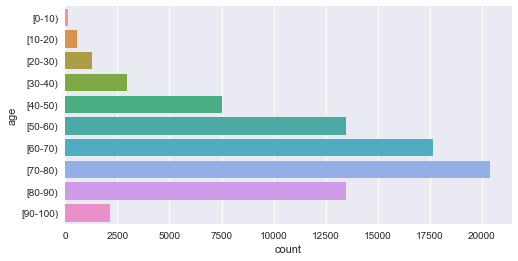

In [7]:
sn.set_style('darkgrid')
fig=plt.figure(figsize=(8,4))
ax=sn.countplot(y="age",data=data)

plt.show()

In [6]:
data['age'] = ['[0-40)' if val in ['[0-10)', '[10-20)', '[20-30)', '[30-40)'] else ('[40-70)' if val in ['[40-50)',  '[50-60)', '[60-70)'] 
               else '[70-100)') for val in data['age']]

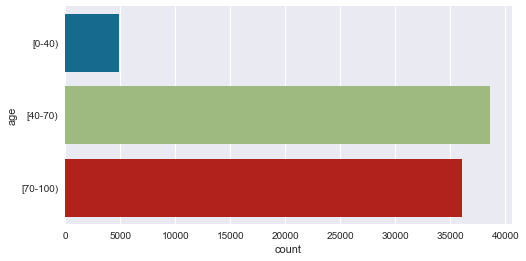

In [9]:
sn.set_style('darkgrid')
fig=plt.figure(figsize=(8,4))
ax=sn.countplot(y="age",data=data)

plt.show()

In [7]:
discharge_types = ['Discharged_to_home','Discharged/transferred_to_another_short_term_hospital','Discharged/transferred_to_SNF',
                   'Discharged/transferred_to_ICF','Discharged/transferred_to_another_type_of_inpatient_care_institution',
                   'Discharged/transferred_to_home_with_home_health_service','Left_AMA',
                   'Discharged/transferred_to_home_under_care_of_Home_IV_provider','Admitted_as_an_inpatient_to_this_hospital',
                   'Neonate_discharged_to_another_hospital_for_neonatal_aftercare','Expired',
                   'Still_patient_or_expected_to_return_for_outpatient_services','Hospice/home','Hospice/medical_facility',
                   'Discharged/transferred_within_this_institution_to_Medicare_approved_swing_bed',
                   'Discharged/transferred/referred_another_institution_for_outpatient_services',
                   'Discharged/transferred/referred_to_this_institution_for_outpatient_services','NULL','Expired_at_home',
                   'Expired_in_a_medical_facility','Expired_place_unknown',
                   'Discharged/transferred_to_another_rehab_fac_including_rehab_units_of_a_hospital',
                   'Discharged/transferred_to_a_long_term_care_hospital',
                   'Discharged/transferred_to_a_nursing_facility_certified_under_Medicaid_but_not_certified_under_Medicare',
                   'Not_Mapped','Unknown/Invalid',
                   'Discharged/transferred_to_another_Type_of_Health_Care_Institution_not_Defined_Elsewhere',
                   'Discharged/transferred_to_a_federal_health_care_facility',
                   'Discharged/transferred/referred_to_a_psychiatric_hospital_of_psychiatric_distinct_part_unit_of_a_hospital',
                   'Discharged/transferred_to_a_Critical_Access_Hospital']

data.discharge_disposition_id.replace(list(range(1,len(discharge_types)+1)),discharge_types, inplace=True)
data.discharge_disposition_id.head()

0            Not_Mapped
1    Discharged_to_home
2    Discharged_to_home
3    Discharged_to_home
4    Discharged_to_home
Name: discharge_disposition_id, dtype: object

In [8]:
admission_sources = ['Physician_Referral','Clinic_Referral','HMO_Referral','Transfer_from_a_hospital',
                     'Transfer_from_a_Skilled_Nursing_Facility_(SNF)','Transfer_from_another_health_care_facility',
                     'Emergency_Room','Court/Law_Enforcement','Not_Available','Transfer_from_critial_access_hospital',
                     'Normal_Delivery','Premature_Delivery','Sick_Baby','Extramural_Birth','Not_Available','NULL',
                     'Transfer_From_Another_Home_Health_Agency','Readmission_to_Same_Home_Health_Agency','Not_Mapped',
                     'Unknown/Invalid','Transfer_from_hospital_inpt/same_fac_reslt_in_a_sep_claim','Born_inside_this_hospital',
                     'Born_outside_this_hospital','Transfer_from_Ambulatory_Surgery_Center','Transfer_from_Hospice']

data.admission_source_id.replace(list(range(1,len(admission_sources)+1)),admission_sources, inplace=True)
data.admission_source_id.head()

0    Physician_Referral
1        Emergency_Room
2        Emergency_Room
3        Emergency_Room
4        Emergency_Room
Name: admission_source_id, dtype: object

In [9]:
admission_types = ['Emergency','Urgent','Elective','Newborn','Not_Available','NULL','Trauma_Center','Not_Mapped']

data.admission_type_id.replace(list(range(1,len(admission_types)+1)),admission_types, inplace=True)
data.admission_type_id.head()

0         NULL
1    Emergency
2    Emergency
3    Emergency
4    Emergency
Name: admission_type_id, dtype: object

In [10]:
data['max_glu_serum'] = ['serum_none' if val == 'None' else ('serum >200' if val == '>200' else 'serum >300' if val == '>300'
                       else 'serum_norm') for val in data['max_glu_serum']]

In [11]:
data['A1Cresult'] = ['A1C_none' if val == 'None' else ('A1C >7' if val == '>7' else 'A1C >8' if val == '>8'
                       else 'A1C_norm') for val in data['A1Cresult']]

In [12]:
data['discharge_disposition_id'] = data['discharge_disposition_id'].replace({'NULL':'discharge_null',
                                                                             'Not_Mapped':'discharge_not_mapped',
                                                                            'Unknown/Invalid':'discharge_invalid'})
data['admission_source_id'] = data['admission_source_id'].replace({'NULL':'admission_source_null',
                                                                             'Not_Mapped':'admission_source_not_mapped',
                                                                            'Unknown/Invalid':'admission_source_invalid',
                                                                  'Not_Available':'admission_source_not_available'})
data['admission_type_id'] = data['admission_type_id'].replace({'NULL':'admission_type_null',
                                                                             'Not_Mapped':'admission_type_not_mapped',
                                                                            'Not_Available':'admission_type_not_available'})

### Getting dummy values for all nominal variables in the dataset

In [13]:
data_age = pd.get_dummies(data['age'])
data_race = pd.get_dummies(data['race'])
data_gender = pd.get_dummies(data['gender'])
data_max_glu_serum = pd.get_dummies(data['max_glu_serum'])
data_A1Cresult = pd.get_dummies(data['A1Cresult'])
data_dischange = pd.get_dummies(data['discharge_disposition_id'])
data_admission_source = pd.get_dummies(data['admission_source_id'])
data_admission_type = pd.get_dummies(data['admission_type_id'])
data_diabetesMed = pd.get_dummies(data['diabetesMed'])

In [14]:
data_insulin = pd.get_dummies(data['insulin'], prefix = ['insulin'])
data_metformin = pd.get_dummies(data['metformin'], prefix = ['metformin'])
data_repaglinide = pd.get_dummies(data['repaglinide'], prefix = ['repaglinide'])
data_nateglinide = pd.get_dummies(data['nateglinide'], prefix = ['nateglinide'])
data_chlorpropamide = pd.get_dummies(data['chlorpropamide'], prefix = ['chlorpropamide'])
data_glimepiride = pd.get_dummies(data['glimepiride'], prefix = ['glimepiride'])
data_acetohexamide = pd.get_dummies(data['acetohexamide'], prefix = ['acetohexamide'])
data_glipizide = pd.get_dummies(data['glipizide'], prefix = ['glipizide'])
data_glyburide = pd.get_dummies(data['glyburide'], prefix = ['glyburide'])
data_tolbutamide = pd.get_dummies(data['tolbutamide'], prefix = ['tolbutamide'])
data_pioglitazone = pd.get_dummies(data['pioglitazone'], prefix = ['pioglitazone'])
data_rosiglitazone = pd.get_dummies(data['rosiglitazone'], prefix = ['rosiglitazone'])
data_acarbose = pd.get_dummies(data['acarbose'], prefix = ['acarbose'])
data_miglitol = pd.get_dummies(data['miglitol'], prefix = ['miglitol'])
data_troglitazone = pd.get_dummies(data['troglitazone'], prefix = ['troglitazone'])
data_tolazamide = pd.get_dummies(data['tolazamide'], prefix = ['tolazamide'])
data_examide = pd.get_dummies(data['examide'], prefix = ['examide'])
data_citoglipton = pd.get_dummies(data['citoglipton'], prefix = ['citoglipton'])
data_glyburide_metformin = pd.get_dummies(data['glyburide-metformin'], prefix = ['glyburide-metformin'])
data_glipizide_metformin = pd.get_dummies(data['glipizide-metformin'], prefix = ['glipizide-metformin'])
data_glimepiride_pioglitazone = pd.get_dummies(data['glimepiride-pioglitazone'], prefix = ['glimepiride-pioglitazone'])
data_metformin_rosiglitazone = pd.get_dummies(data['metformin-rosiglitazone'], prefix = ['metformin-rosiglitazone'])
data_metformin_pioglitazone = pd.get_dummies(data['metformin-pioglitazone'], prefix = ['metformin-pioglitazone'])
data_change = pd.get_dummies(data['change'], prefix = ['change'])

In [15]:
data = pd.concat([data, data_age, data_race, data_gender, data_max_glu_serum, data_A1Cresult, data_dischange, data_admission_source,
                  data_admission_type, data_diabetesMed, data_insulin, data_metformin, data_repaglinide, data_nateglinide,
                 data_chlorpropamide, data_glimepiride, data_acetohexamide, data_glipizide, data_glyburide, data_tolbutamide,
                 data_pioglitazone, data_rosiglitazone, data_acarbose, data_miglitol, data_troglitazone, data_tolazamide,
                 data_examide, data_citoglipton, data_glyburide_metformin, data_glipizide_metformin, data_glimepiride_pioglitazone,
                 data_metformin_rosiglitazone, data_metformin_pioglitazone, data_change], axis=1)
data.drop(['race','gender','age','admission_type_id','discharge_disposition_id','admission_source_id','max_glu_serum',
           'A1Cresult','metformin','repaglinide','nateglinide','insulin',
           'chlorpropamide','glimepiride','acetohexamide','glipizide','glyburide','tolbutamide','pioglitazone','rosiglitazone',
           'acarbose','miglitol','troglitazone','tolazamide','examide','citoglipton','insulin','glyburide-metformin',
           'glipizide-metformin','glimepiride-pioglitazone','metformin-rosiglitazone','metformin-pioglitazone','change',
           'diabetesMed'], axis=1, inplace=True)

In [17]:
data.to_csv("diabetes_modified.csv")

In [16]:
data.astype('int64')

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,...,['glyburide-metformin']_Up,['glipizide-metformin']_No,['glipizide-metformin']_Steady,['glimepiride-pioglitazone']_No,['glimepiride-pioglitazone']_Steady,['metformin-rosiglitazone']_No,['metformin-pioglitazone']_No,['metformin-pioglitazone']_Steady,['change']_Ch,['change']_No
0,1,41,0,1,0,0,0,1,0,0,...,0,1,0,1,0,1,1,0,0,1
1,3,59,0,18,0,0,0,0,1,0,...,0,1,0,1,0,1,1,0,1,0
2,2,11,5,13,2,0,1,0,1,0,...,0,1,0,1,0,1,1,0,0,1
3,2,44,1,16,0,0,0,0,1,0,...,0,1,0,1,0,1,1,0,1,0
4,1,51,0,8,0,0,0,0,0,1,...,0,1,0,1,0,1,1,0,1,0
5,3,31,6,16,0,0,0,0,0,1,...,0,1,0,1,0,1,1,0,0,1
6,4,70,1,21,0,0,0,0,0,0,...,0,1,0,1,0,1,1,0,1,0
7,5,73,0,12,0,0,0,0,0,1,...,0,1,0,1,0,1,1,0,0,1
8,13,68,2,28,0,0,0,0,0,0,...,0,1,0,1,0,1,1,0,1,0
9,9,47,2,17,0,0,0,1,0,0,...,0,1,0,1,0,1,1,0,0,1


In [17]:
x = data.drop(["readmitted"], axis=1)
y = data["readmitted"]

### Feature Extraction using Random Forest Cross Validation

In [18]:
from sklearn.feature_selection import RFECV
clf = RandomForestClassifier(random_state = 100, n_jobs = -1, class_weight = {0:1,1:9})
rfecv = RFECV(clf, step=1, cv = 3, n_jobs = -1)
rfecv = rfecv.fit(x, y)

In [19]:
print('Optimal number of features:', rfecv.n_features_)
print('Support:', x.columns[rfecv.support_])
print('Feature rankings:', rfecv.ranking_)

Optimal number of features: 44
Support: Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses',
       '[40-70)', '[70-100)', 'AfricanAmerican', 'Caucasian', 'Female', 'Male',
       'A1C >8', 'A1C_none', 'Discharged/transferred_to_SNF',
       'Discharged/transferred_to_home_with_home_health_service',
       'Discharged_to_home', 'Expired', 'Emergency_Room', 'Physician_Referral',
       'Elective', 'Emergency', 'Urgent', 'No', '['insulin']_Down',
       '['insulin']_No', '['insulin']_Steady', '['insulin']_Up',
       '['metformin']_No', '['metformin']_Steady', '['glimepiride']_No',
       '['glipizide']_No', '['glipizide']_Steady', '['glyburide']_No',
       '['glyburide']_Steady', '['pioglitazone']_Steady',
       '['rosiglitazone']_No', '['change']_Ch', '['change']_No'],
      dtype='object')
Feature rankings: [  1   1   1   1   1

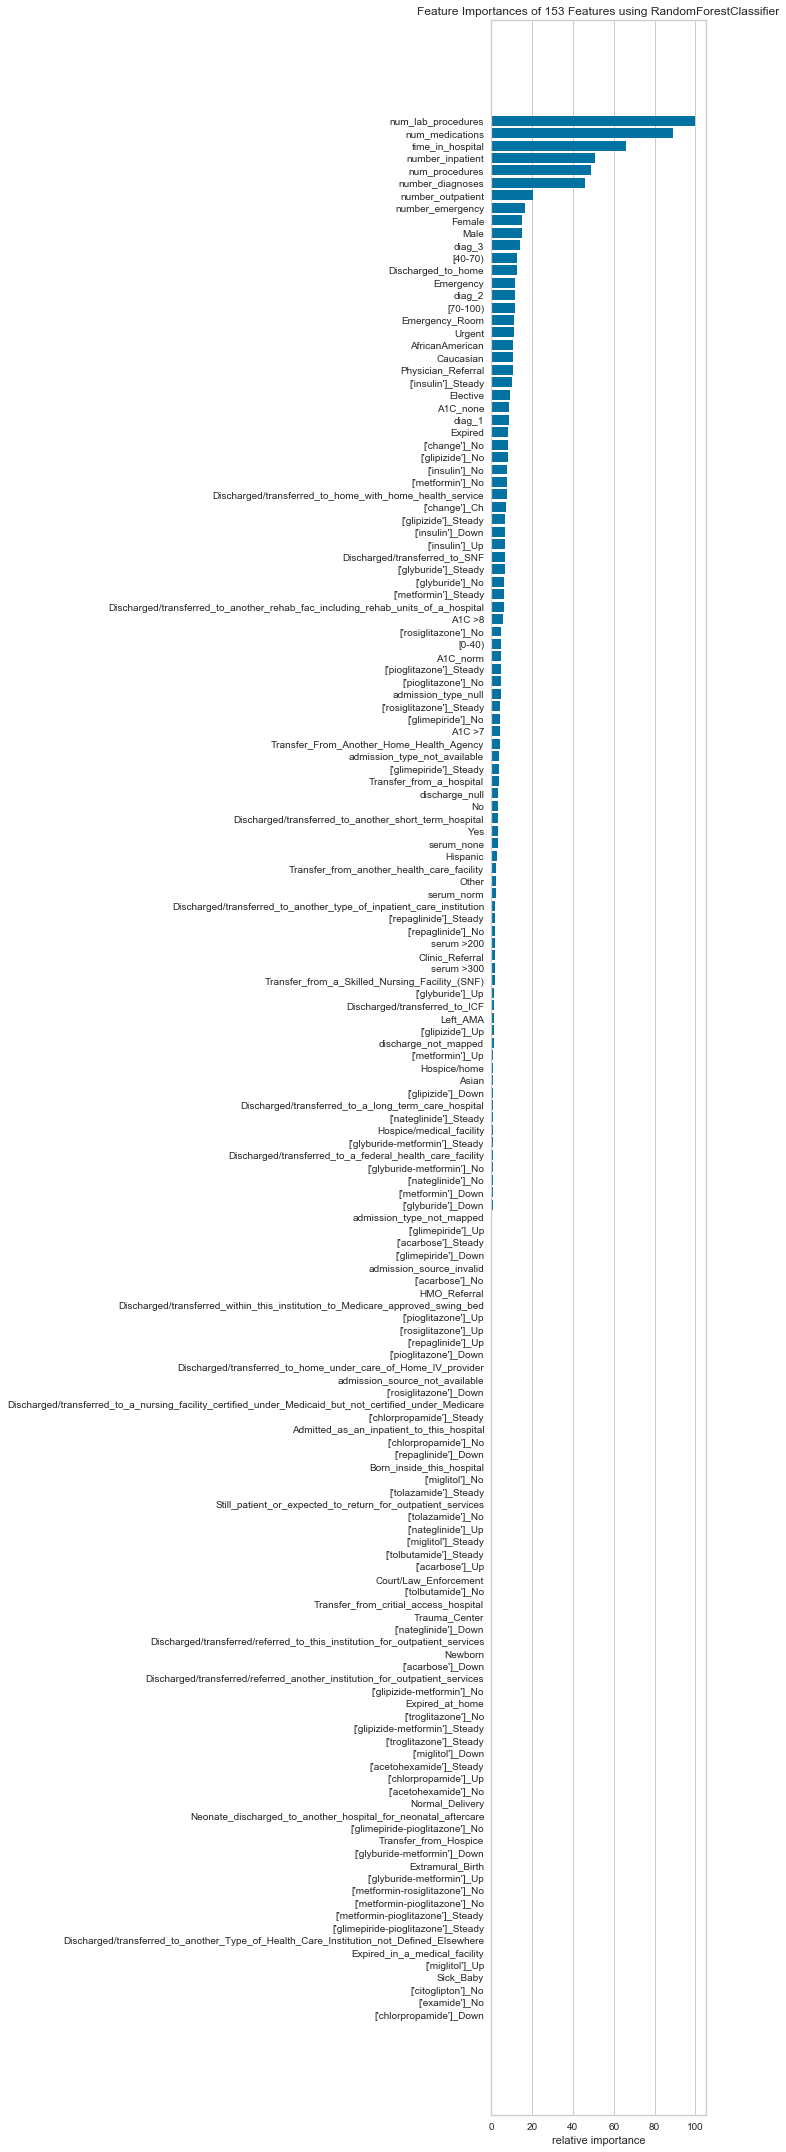

In [20]:
from yellowbrick.features.importances import FeatureImportances
fig = plt.figure(figsize = (10,30))
ax = fig.add_subplot()

viz = FeatureImportances(clf, ax=ax)
viz.fit(x, y)
viz.poof()

In [37]:
np.sort(clf.feature_importances_)

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 4.80562556e-07,
       5.26331094e-07, 6.81733232e-07, 1.37567104e-06, 1.81524922e-06,
       2.34680607e-06, 2.51133104e-06, 3.50899458e-06, 3.64797629e-06,
       5.16351550e-06, 6.32307626e-06, 7.51572349e-06, 7.60759366e-06,
       7.74603826e-06, 8.98505415e-06, 1.04038125e-05, 1.18741089e-05,
       1.46225078e-05, 1.65039198e-05, 1.80497386e-05, 1.91876077e-05,
       2.00314559e-05, 2.08789045e-05, 2.74338359e-05, 2.76522350e-05,
       2.84186642e-05, 3.07338367e-05, 3.19542490e-05, 3.26605650e-05,
       4.99945126e-05, 5.02746364e-05, 5.46461083e-05, 5.74478566e-05,
       8.30963528e-05, 9.89854691e-05, 1.12819302e-04, 1.22190187e-04,
       1.32808302e-04, 1.36353001e-04, 1.65712769e-04, 2.51198164e-04,
       2.51840309e-04, 2.56878774e-04, 2.89919839e-04, 2.99253073e-04,
      

In [20]:
x_rfe = rfecv.transform(x)

In [26]:
import statsmodels.api as sm
lm = sm.OLS(y,sm.add_constant(x_rfe)).fit()
logit = sm.Logit(y, sm.add_constant(x_rfe))
result = logit.fit(start_params=lm.params,method = 'nm',maxiter=200)
result.summary()

C:\Users\adity\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             readmitted   No. Observations:                79584
Model:                          Logit   Df Residuals:                    79542
Method:                           MLE   Df Model:                           41
Date:                Thu, 06 Sep 2018   Pseudo R-squ.:                  -1.079
Time:                        15:54:44   Log-Likelihood:                -58088.
converged:                      False   LL-Null:                       -27934.
                                        LLR p-value:                     1.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0245        nan        nan        nan         nan         nan
x1             0.0004        nan        nan        nan         nan         nan
x2             0.0001        nan        nan        nan         nan         nan
x3            -0.0004        nan        nan        nan         nan         nan
x4             0.0005        nan        nan        nan         nan         nan
x5            -0.0006        nan        nan        nan         nan         nan
x6             0.0061        nan        nan        nan         nan         nan
x7             0.0355        nan        nan        nan         nan         nan
x8             0.0158        nan        nan        nan         nan         nan
x9             0.0122        nan        nan        nan         nan         nan
x10            0.0070        nan        nan        nan         nan         nan
x11            0.0038        nan        nan        nan         nan         nan
x12            0.0014        nan        nan        nan         nan         nan
x13            0.0082        nan        nan        nan         nan         nan
x14            0.0040        nan        nan        nan         nan         nan
x15            0.0028        nan        nan        nan         nan         nan
x16            0.0111        nan        nan        nan         nan         nan
x17            0.0142        nan        nan        nan         nan         nan
x18           -0.0011        nan        nan        nan         nan         nan
x19            0.0107        nan        nan        nan         nan         nan
x20           -0.0275        nan        nan        nan         nan         nan
x21           -0.0490        nan        nan        nan         nan         nan
x22           -0.0704        nan        nan        nan         nan         nan
x23           -0.1812        nan        nan        nan         nan         nan
x24            0.0074        nan        nan        nan         nan         nan
x25            0.0135        nan        nan        nan         nan         nan
x26           -0.0050        nan        nan        nan         nan         nan
x27            0.0016        nan        nan        nan         nan         nan
x28            0.0026        nan        nan        nan         nan         nan
x29           -0.0173        nan        nan        nan         nan         nan
x30            0.0158        nan        nan        nan         nan         nan
x31            0.0011        nan        nan        nan         nan         nan
x32            0.0012        nan        nan        nan         nan         nan
x33            0.0087        nan        nan        nan         nan         nan
x34            0.0150        nan        nan        nan         nan         nan
x35            0.0030        nan        nan        nan         nan         nan
x36            0.0076        nan        nan        nan         nan         nan
x37           -0.0236        nan        nan        nan         nan         nan
x3

In [23]:
lm = sm.OLS(y,sm.add_constant(x_rfe)).fit()
lm.params

const    0.026506
x1       0.000388
x2       0.000136
x3      -0.000457
x4       0.000514
x5      -0.000637
x6       0.006117
x7       0.037339
x8       0.015831
x9       0.012059
x10      0.006949
x11      0.004130
x12      0.001365
x13      0.007966
x14      0.003960
x15      0.002978
x16      0.010804
x17      0.015702
x18     -0.001077
x19      0.011014
x20     -0.026538
x21     -0.047173
x22     -0.064155
x23     -0.175007
x24      0.007268
x25      0.013239
x26     -0.004845
x27      0.001588
x28      0.002552
x29     -0.016696
x30      0.015606
x31      0.001055
x32      0.001175
x33      0.008670
x34      0.015572
x35      0.002929
x36      0.007762
x37     -0.023602
x38     -0.023129
x39      0.003692
x40      0.001609
x41     -0.007187
x42      0.010599
x43      0.012708
x44      0.013798
dtype: float64

In [22]:
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV

In [23]:
def classifier_metrics(estimator,y_pred):
    class_metrics = {'Accuracy' : metrics.accuracy_score(y, y_pred),
                     'Precision' : metrics.precision_score(y, y_pred),
                     'Recall' : metrics.recall_score(y, y_pred),
                     'F1 Score' : metrics.f1_score(y, y_pred)
                    }


    df_metrics = pd.DataFrame.from_dict(class_metrics, orient='index')
    print('\nConfusion Matrix:')
    skplt.metrics.plot_confusion_matrix(y, y_pred)
    
    print('\nClassification Report:')
    print(metrics.classification_report(y,y_pred,digits=2))
    
    print('\nMetrics:')
    print(df_metrics)
    
    return  df_metrics

In [24]:
def plot_roc(model,x_test,y):
    model_proba = cross_val_predict(model, x_test, y, cv=3, n_jobs=-1, verbose=1, method = 'predict_proba')
    fig = plt.figure()
    ax1 = fig.add_subplot()
    skplt.metrics.plot_roc(y,model_proba ,figsize = (15,7),title_fontsize='large',text_fontsize='large')                
    return None

In [25]:
def precision_recall(model,x_test,y):
    model_proba = cross_val_predict(model, x_test, y, cv=3, n_jobs=-1, verbose=1, method = 'predict_proba')
    fig = plt.figure()
    ax1 = fig.add_subplot()
    skplt.metrics.plot_precision_recall(y,model_proba,figsize = (15,7),title_fontsize='large',text_fontsize='large')                 
    return None

### Logistic Regression

In [35]:
from sklearn.linear_model import LogisticRegression
log = LogisticRegression(solver = 'saga', random_state = 100, class_weight = {0:1,1:9}, penalty = 'l1', n_jobs = -1)
param_grid = {'C':[1,5,10]}
grid_search1= GridSearchCV(log,param_grid, cv=3, scoring = 'accuracy', n_jobs=-1, verbose = 2)
grid_search1.fit(x_rfe,y)

print("Best Parameters : {}".format(grid_search1.best_params_))
print("Best cross_val score : {}".format(grid_search1.best_score_))

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:   29.2s remaining:   36.5s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   36.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   36.8s finished


Best Parameters : {'C': 5}
Best cross_val score : 0.577741757137113


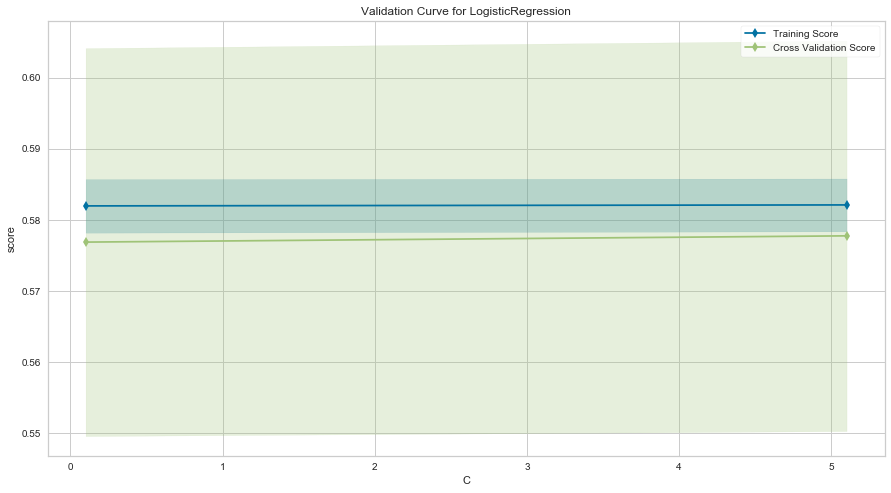

In [40]:
fig = plt.figure(figsize = (15,8))
ax = fig.add_subplot(111)
viz = ValidationCurve(log, ax=ax, param_name="C", param_range=np.arange(0.1,10.1,5), cv=3, scoring="accuracy")
viz.fit(x_rfe, y)
viz.poof()

In [41]:
logreg = LogisticRegression(solver = 'saga', random_state = 100, class_weight = {0:1,1:9}, penalty = 'l1', n_jobs = -1, C=5)
logreg.fit(x_rfe,y)
log_pred = cross_val_predict(logreg, x_rfe, y, cv=3, n_jobs=-1, verbose=1)

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   20.8s finished



Confusion Matrix:

Classification Report:
             precision    recall  f1-score   support

          0       0.93      0.57      0.70     70658
          1       0.16      0.66      0.26      8926

avg / total       0.84      0.58      0.65     79584


Metrics:
                  0
Accuracy   0.577742
Precision  0.161514
Recall     0.659646
F1 Score   0.259492


,0
Accuracy,0.577742
Precision,0.161514
Recall,0.659646
F1 Score,0.259492


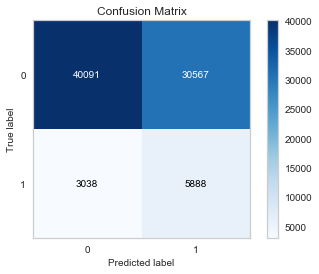

In [42]:
classifier_metrics(logreg,log_pred)

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   16.5s finished


<Figure size 432x288 with 0 Axes>

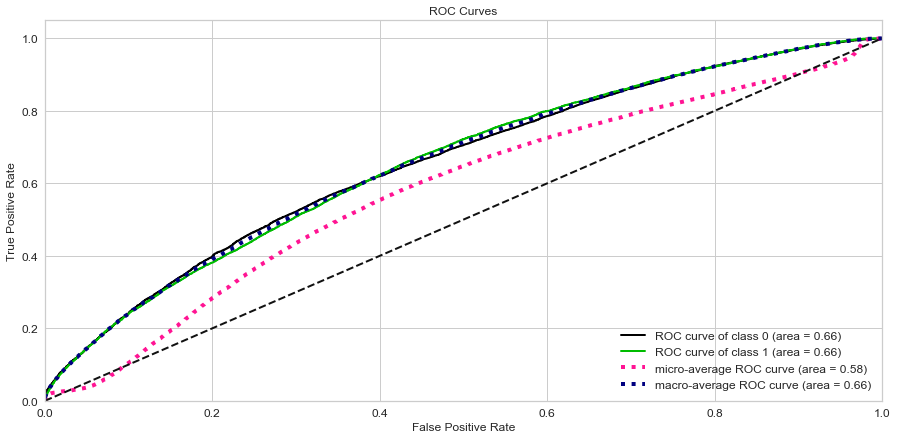

In [43]:
plot_roc(logreg,x_rfe,y)

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   17.2s finished


<Figure size 432x288 with 0 Axes>

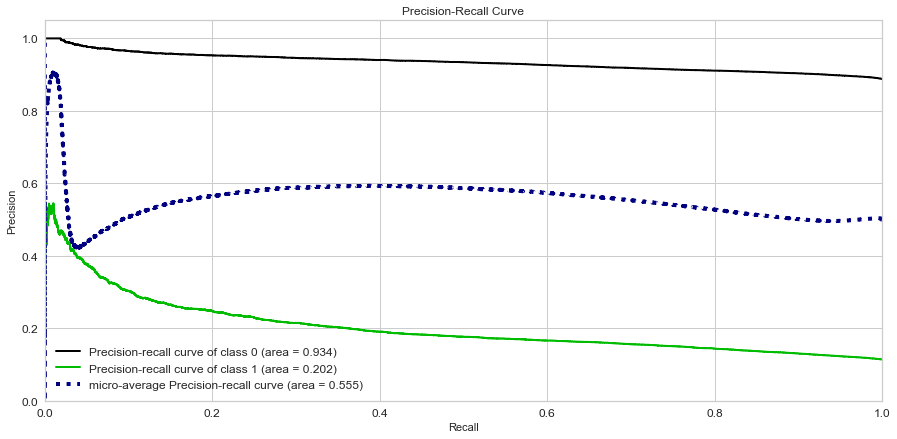

In [44]:
precision_recall(logreg,x_rfe,y)

### Random Forest

In [27]:
from sklearn.ensemble import RandomForestClassifier
ranf = RandomForestClassifier(random_state=100, oob_score=True, n_jobs=-1, class_weight = {0:1,1:9}, min_samples_leaf = 100)
param_grid = {'n_estimators':[100,250,500]}
grid_search3= GridSearchCV(ranf,param_grid, cv=3, scoring = 'accuracy', n_jobs=-1, verbose=2)
grid_search3.fit(x_rfe,y)

print("Best Parameters : {}".format(grid_search3.best_params_))
print("Best cross_val score : {}".format(grid_search3.best_score_))

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:   24.2s remaining:   30.3s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  1.1min finished


Best Parameters : {'n_estimators': 250}
Best cross_val score : 0.5619722557297949


In [28]:
ranfor = RandomForestClassifier(random_state=100, oob_score=True, n_jobs=-1, class_weight = {0:1,1:9}, n_estimators=250,
                               min_samples_leaf = 100)
ranfor.fit(x_rfe,y)
ranfor_pred = cross_val_predict(ranfor, x_rfe, y, cv=3, n_jobs=-1, verbose=1)

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   19.9s finished



Confusion Matrix:

Classification Report:
             precision    recall  f1-score   support

          0       0.93      0.55      0.69     70658
          1       0.16      0.68      0.26      8926

avg / total       0.84      0.56      0.64     79584


Metrics:
                  0
Accuracy   0.561972
Precision  0.159408
Recall     0.679924
F1 Score   0.258266


,0
Accuracy,0.561972
Precision,0.159408
Recall,0.679924
F1 Score,0.258266


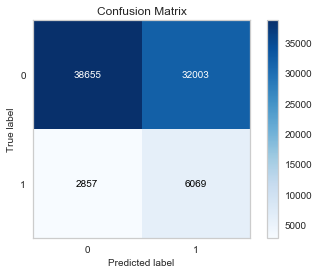

In [29]:
classifier_metrics(ranfor,ranfor_pred)

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   19.0s finished


<Figure size 432x288 with 0 Axes>

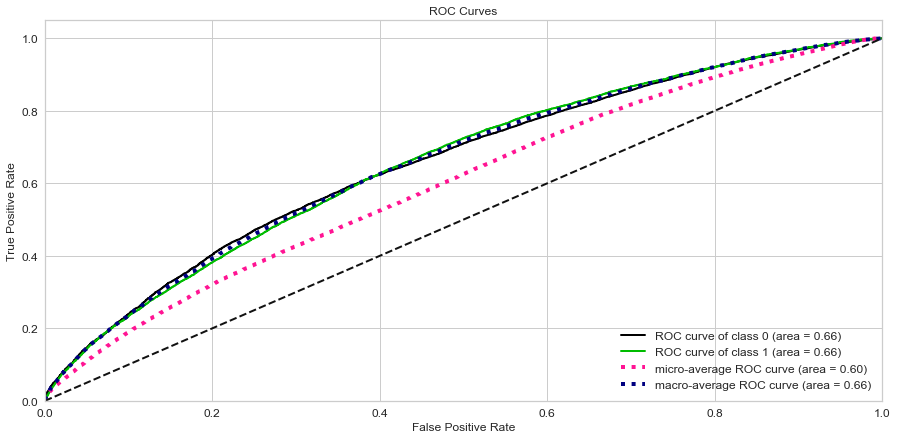

In [66]:
plot_roc(ranfor,x_rfe,y)

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   18.6s finished


<Figure size 432x288 with 0 Axes>

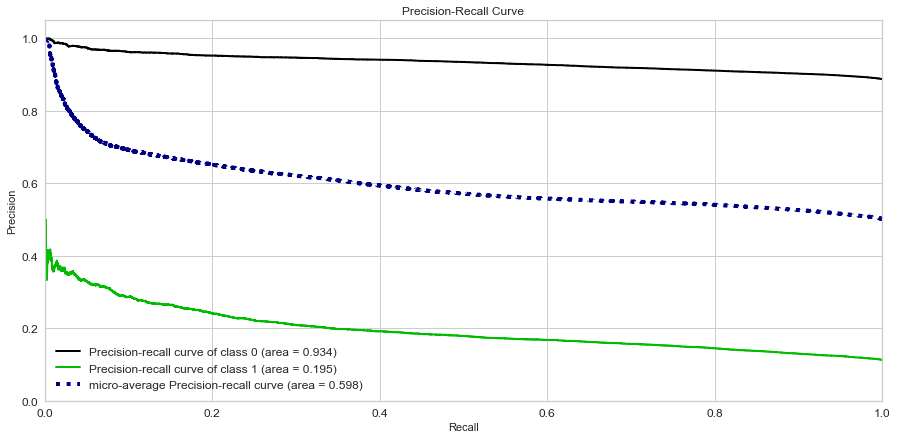

In [67]:
precision_recall(ranfor,x_rfe,y)

### Boosting can improve model performance

In [69]:
from sklearn.ensemble import AdaBoostClassifier

adaboost = AdaBoostClassifier(ranfor, random_state = 10)
adaboost.fit(x_rfe, y)
adaboost_pred = cross_val_predict(adaboost, x_rfe, y, cv=3, n_jobs=-1, verbose=1)

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  5.1min finished



Confusion Matrix:

Classification Report:
             precision    recall  f1-score   support

          0       1.00      0.00      0.00     70658
          1       0.11      1.00      0.20      8926

avg / total       0.90      0.11      0.02     79584


Metrics:
                  0
Accuracy   0.112309
Precision  0.112175
Recall     1.000000
F1 Score   0.201722


,0
Accuracy,0.112309
Precision,0.112175
Recall,1.000000
F1 Score,0.201722


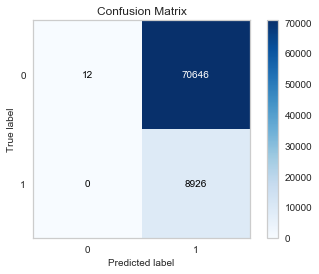

In [73]:
classifier_metrics(adaboost,adaboost_pred)

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

adaboost1 = AdaBoostClassifier(ranfor, random_state = 10, learning_rate = 0.01)
param_grid = {'n_estimators':[10,50,100]}
grid_search_adaboost= GridSearchCV(adaboost1,param_grid, cv=3, scoring = 'accuracy', n_jobs=-1, verbose=2)
grid_search_adaboost.fit(x_rfe, y)

print("Best Parameters : {}".format(grid_search_adaboost.best_params_))
print("Best cross_val score : {}".format(grid_search_adaboost.best_score_))

Fitting 3 folds for each of 3 candidates, totalling 9 fits


In [77]:
adaboost_ran = AdaBoostClassifier(ranfor, random_state=10, n_estimators = 100, learning_rate = 0.01)
adaboost_ran.fit(x_rfe,y)
adaboost_ran_pred = cross_val_predict(adaboost_ran, x_rfe, y, cv=3, n_jobs=-1, verbose=1)

KeyboardInterrupt: 

In [ ]:
classifier_metrics(adaboost_ran,adaboost_ran_pred)

### Importing test data set

In [56]:
test = pd.read_csv('test_data.csv', na_values=['?'])
test.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed
0,15738,63555939,Caucasian,Female,[90-100),NaN,3,3,4,12,...,No,No,Steady,No,No,No,No,No,Ch,Yes
1,62256,49726791,AfricanAmerican,Female,[60-70),NaN,3,1,2,1,...,No,No,Steady,No,No,No,No,No,No,Yes
2,150006,22864131,NaN,Female,[50-60),NaN,2,1,4,2,...,No,No,Down,No,No,No,No,No,Ch,Yes
3,183930,107400762,Caucasian,Female,[80-90),NaN,2,6,1,11,...,No,No,No,No,No,No,No,No,No,No
4,248916,115196778,Caucasian,Female,[50-60),NaN,1,1,1,2,...,No,No,Steady,No,No,No,No,No,No,Yes


In [57]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20352 entries, 0 to 20351
Data columns (total 49 columns):
encounter_id                20352 non-null int64
patient_nbr                 20352 non-null int64
race                        19892 non-null object
gender                      20352 non-null object
age                         20352 non-null object
weight                      627 non-null object
admission_type_id           20352 non-null int64
discharge_disposition_id    20352 non-null int64
admission_source_id         20352 non-null int64
time_in_hospital            20352 non-null int64
payer_code                  12327 non-null object
medical_specialty           10338 non-null object
num_lab_procedures          20352 non-null int64
num_procedures              20352 non-null int64
num_medications             20352 non-null int64
number_outpatient           20352 non-null int64
number_emergency            20352 non-null int64
number_inpatient            20352 non-null int64
diag_

In [58]:
percentage_missing_test = (test.isnull().sum()*100)/(len(test))
print(percentage_missing_test)

encounter_id                 0.000000
patient_nbr                  0.000000
race                         2.260220
gender                       0.000000
age                          0.000000
weight                      96.919222
admission_type_id            0.000000
discharge_disposition_id     0.000000
admission_source_id          0.000000
time_in_hospital             0.000000
payer_code                  39.431014
medical_specialty           49.204009
num_lab_procedures           0.000000
num_procedures               0.000000
num_medications              0.000000
number_outpatient            0.000000
number_emergency             0.000000
number_inpatient             0.000000
diag_1                       0.014741
diag_2                       0.343947
diag_3                       1.464230
number_diagnoses             0.000000
max_glu_serum                0.000000
A1Cresult                    0.000000
metformin                    0.000000
repaglinide                  0.000000
nateglinide 

In [59]:
test.drop(['weight','payer_code','medical_specialty','metformin','repaglinide','nateglinide','chlorpropamide','glimepiride',
               'acetohexamide','glipizide','glyburide','tolbutamide','pioglitazone','rosiglitazone','acarbose','miglitol',
               'troglitazone','tolazamide','examide','citoglipton','glyburide-metformin','glipizide-metformin',
               'glimepiride-pioglitazone','metformin-rosiglitazone','metformin-pioglitazone','diag_2','diag_3',
               'encounter_id','patient_nbr'], axis=1, inplace=True)

In [61]:
test.dropna(subset = ["race","diag_1"], inplace=True)
test = test[test["gender"] != "Unknown/Invalid"]
test.reset_index(drop=True, inplace=True)

In [80]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19889 entries, 0 to 19888
Data columns (total 43 columns):
time_in_hospital      19889 non-null int64
num_lab_procedures    19889 non-null int64
num_procedures        19889 non-null int64
num_medications       19889 non-null int64
number_outpatient     19889 non-null int64
number_emergency      19889 non-null int64
number_inpatient      19889 non-null int64
diag_1                19889 non-null int64
number_diagnoses      19889 non-null int64
[0-50)                19889 non-null uint8
[50-60)               19889 non-null uint8
[60-70)               19889 non-null uint8
[70-80)               19889 non-null uint8
[80-100)              19889 non-null uint8
AfricanAmerican       19889 non-null uint8
Asian                 19889 non-null uint8
Caucasian             19889 non-null uint8
Hispanic              19889 non-null uint8
Other                 19889 non-null uint8
Female                19889 non-null uint8
Male                  19889 non

In [62]:
test['diag_1'] = test['diag_1'].astype(str)
test['diag_1'] = pd.Series([1 if val.startswith('250') else 0 for val in test['diag_1']], index=test.index)

In [63]:
test['age'] = pd.Series(['[0-50)' if val in ['[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)'] else val 
                         for val in test['age']], index=test.index)
test['age'] = pd.Series(['[80-100)' if val in ['[80-90)', '[90-100)'] else val 
                         for val in test['age']], index=test.index)

In [64]:
test['discharge_disposition_id'] = pd.Series(['Home' if val == 1 else 'Other' 
                                              for val in test['discharge_disposition_id']], index=test.index)

In [65]:
test['admission_source_id'] = pd.Series(['ER' if val == 7 else 'Other' 
                                              for val in test['admission_source_id']], index=test.index)

In [66]:
test['admission_type_id'] = pd.Series(['Emergency' if val == 1 else 'Other' 
                                              for val in test['admission_type_id']], index=test.index)

In [67]:
test_age = pd.get_dummies(test['age'])
test_race = pd.get_dummies(test['race'])
test_gender = pd.get_dummies(test['gender'])
test_max_glu_serum = pd.get_dummies(test['max_glu_serum'])
test_A1Cresult = pd.get_dummies(test['A1Cresult'])
test_insulin = pd.get_dummies(test['insulin'])
test_change = pd.get_dummies(test['change'])
test_diabetesMed = pd.get_dummies(test['diabetesMed'])
test_discharge_disposition_id = pd.get_dummies(test['discharge_disposition_id'])
test_admission_source_id = pd.get_dummies(test['admission_source_id'])
test_admission_type_id = pd.get_dummies(test['admission_type_id'])

test = pd.concat([test, test_age, test_race, test_gender, test_max_glu_serum, test_A1Cresult, 
                  test_insulin, test_change, test_diabetesMed, test_discharge_disposition_id, 
                  test_admission_source_id, test_admission_type_id], axis=1)
test.drop(['age', 'race', 'gender', 'max_glu_serum', 'A1Cresult', 'insulin', 'change', 
                  'diabetesMed', 'discharge_disposition_id', 'admission_source_id', 
                  'admission_type_id'], axis=1, inplace=True)

### Predictions

In [79]:
y_pred = logreg.predict(test)
y_pred_df = pd.DataFrame(y_pred)
y_pred_df.to_csv('output.csv')
test.to_csv('test_final.csv')

### Conclusion

### References

#### https://www.hindawi.com/journals/bmri/2014/781670/
#### https://www.kaggle.com/c/diabetes-hospital-readmission/data